# Project 2: Moneyball
### by Jerry Catron
_Inspired by the 2011 film featuring my uglier doppelganger Brad Pitt, this report will analyze how efficient Major League Baseball teams have been historically at spending money and getting wins in return._

## The Data
We will be using an SQLite database curated by Sean Lahman that has information about the teams and players for each year. Currently we are only analyzing the data through the 2014 season.

To download this database we will be using the `download()` method of Python's `wget` module (**Note:** You must `pip install wget` if you haven't already) We pass in the URL of the SQLite database file, as well as the path of where we want the database to be stored. For easy access, we will store it in the current working directory under the name 'lahman2014.sqlite'.

To handle the path we can use Python's `os` module. The `os.getcwd()` method returns the current working directory. We can use this and the `os.path.join()` method to create a path-like object out of our current working directory and a string literal for the file name.

In [1]:
import wget
import os

url = 'https://github.com/jknecht/baseball-archive-sqlite/raw/master/lahman2014.sqlite'
path = os.path.join(os.getcwd(), 'lahman2014.sqlite')
wget.download(url, path)


Now that we have downloaded this database, we need to connect to it using the `sqlite3` module. We store our Connection object in the variable `conn`. This object is what persists changes made to the database. Then we use a Cursor object `cur` pointing to the `conn` Connection to perform queries and store intermediate tables.

In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('lahman2014.sqlite')
cur = conn.cursor()

---
## **Part 1: Wrangling**
---

### Problem 1

Our objective is to compute a relation containing the total payroll and winning percentage each year for every team.

To do this we will `SELECT` the yearID, teamID, franchID, W(ins), and G(ames) from the Teams table. We also create a new column `winning_percentage` using the formula ((number of wins / number of games) * 100). We then `LEFT JOIN` the selected relation with a nested `SELECT` that calculates the `total_payroll` for each year/team combination from the `Salaries` table. We used yearID as the key to join on, but included a `WHERE t.teamID = s.teamID` clause to ensure the teamID's matched too. Because this is a `LEFT JOIN` all observations from `Teams` would still be included even if there is missing `salary` data. However, to answer our question on spending efficiency, and observations without `salary` data are useless, thus the `WHERE t.teamID = s.teamID` command excludes any observations that aren't in the modified `Salaries` table. The resulting table does not have any missing data.

To simplify our analysis, we will use SQL queries to wrangle the data into `pandas` `DataFrames` using the `pandas.read_sql()` method. We will pass in a string representing our SQL query `join_query` and our SQLite Connection object `conn`.

In [3]:
join_query = ('''SELECT t.yearID, 
                        t.teamID, 
                        t.franchID,
                        t.lgID, 
                        s.total_payroll, 
                        (((1.0 * t.W) / t.G) * 100) AS winning_percentage, 
                        t.W as wins, 
                        t.G as games 
                 FROM Teams AS t 
                    LEFT JOIN (
                        SELECT yearID, 
                               teamID, 
                               SUM(salary) AS total_payroll 
                        FROM Salaries 
                        GROUP BY yearID, 
                                 teamID
                    ) AS s 
                        ON t.yearID = s.yearID 
                 WHERE t.teamID = s.teamID
              ''')

df = pd.read_sql(join_query, conn)
df.head()


,yearID,teamID,franchID,lgID,total_payroll,winning_percentage,wins,games
0,1985,ATL,ATL,NL,14807000.0,40.740741,66,162
1,1985,BAL,BAL,AL,11560712.0,51.552795,83,161
2,1985,BOS,BOS,AL,10897560.0,49.693252,81,163
3,1985,CAL,ANA,AL,14427894.0,55.555556,90,162
4,1985,CHA,CHW,AL,9846178.0,52.147239,85,163


---
## **Part 2: Exploratory Data Analysis**
---
## *Payroll Distribution*

### Problem 2

For this problem we only need data from the years 1990-2014, so we use `pandas.DataFrame.loc` indexing method to return a new `DataFrame` that only has obsrevations where the column `yearID` is greater than 1989.

In [4]:
df_1990 = df.loc[df['yearID'] > 1989]
df_1990.head() 

,yearID,teamID,franchID,lgID,total_payroll,winning_percentage,wins,games
130,1990,ATL,ATL,NL,14555501.0,40.123457,65,162
131,1990,BAL,BAL,AL,9680084.0,47.204969,76,161
132,1990,BOS,BOS,AL,20558333.0,54.320988,88,162
133,1990,CAL,ANA,AL,21720000.0,49.382716,80,162
134,1990,CHA,CHW,AL,9491500.0,58.024691,94,162


This problem asks us to analyze the relationship between `total_payroll` and time (1990-2014). To plot this, we must transform our data a bit so that every year observation has payroll values for each team. We will use the `DataFrame.pivot` method to do this. We pass in the columns to be used as the index, columns, and values in our "wide" `DataFrame`.

In [5]:
df_1990_pivot = df_1990.pivot('yearID', 'teamID', 'total_payroll')
df_1990_pivot.head()

teamID,ANA,ARI,ATL,BAL,BOS,CAL,CHA,CHN,CIN,CLE,...,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
yearID,,,,,,,,,,,,,,,,,,,,,
1990,NaN,NaN,14555501.0,9680084.0,20558333.0,21720000.0,9491500.0,13624000.0,14370000.0,14487000.0,...,13173667.0,15556000.0,17588334.0,12553667.0,19335333.0,20523334.0,NaN,14874372.0,17756834.0,NaN
1991,NaN,NaN,18403500.0,17519000.0,35167500.0,33060001.0,16919667.0,23175667.0,26305333.0,17635000.0,...,22487332.0,23634667.0,22150001.0,15691833.0,30967666.0,21860001.0,NaN,18224500.0,19902417.0,NaN
1992,NaN,NaN,34625333.0,23780667.0,43610584.0,34749334.0,30160833.0,29829686.0,35931499.0,9373044.0,...,24383834.0,33944167.0,26854167.0,23179833.0,33163168.0,27583836.0,NaN,30128167.0,44788666.0,NaN
1993,NaN,NaN,41641417.0,29096500.0,37120583.0,28588334.0,39696166.0,39386666.0,44879666.0,18561000.0,...,28538334.0,24822467.0,25511333.0,32696333.0,35050000.0,23367334.0,NaN,36376959.0,47279166.0,NaN
1994,NaN,NaN,49383513.0,38849769.0,37859084.0,25156218.0,39183836.0,36287333.0,40961833.0,30490500.0,...,31599000.0,24217250.0,14916333.0,29228500.0,42638666.0,29275601.0,NaN,32973597.0,43433668.0,NaN


Notice however that there are some missing values for the years 1990-1994 for ANA, ARI, and WAS. This is because some of the teams didn't exist at the time. To alleviate this, we are going to use the column `franchID` as our variables in a new `pivot()`.

In [6]:
df_1990_pivot_fran = df_1990.pivot('yearID', 'franchID', 'total_payroll')
df_1990_pivot_fran.head()

franchID,ANA,ARI,ATL,BAL,BOS,CHC,CHW,CIN,CLE,COL,...,PHI,PIT,SDP,SEA,SFG,STL,TBD,TEX,TOR,WSN
yearID,,,,,,,,,,,,,,,,,,,,,
1990,21720000.0,NaN,14555501.0,9680084.0,20558333.0,13624000.0,9491500.0,14370000.0,14487000.0,NaN,...,13173667.0,15556000.0,17588334.0,12553667.0,19335333.0,20523334.0,NaN,14874372.0,17756834.0,16586388.0
1991,33060001.0,NaN,18403500.0,17519000.0,35167500.0,23175667.0,16919667.0,26305333.0,17635000.0,NaN,...,22487332.0,23634667.0,22150001.0,15691833.0,30967666.0,21860001.0,NaN,18224500.0,19902417.0,10732333.0
1992,34749334.0,NaN,34625333.0,23780667.0,43610584.0,29829686.0,30160833.0,35931499.0,9373044.0,NaN,...,24383834.0,33944167.0,26854167.0,23179833.0,33163168.0,27583836.0,NaN,30128167.0,44788666.0,15822334.0
1993,28588334.0,NaN,41641417.0,29096500.0,37120583.0,39386666.0,39696166.0,44879666.0,18561000.0,10353500.0,...,28538334.0,24822467.0,25511333.0,32696333.0,35050000.0,23367334.0,NaN,36376959.0,47279166.0,18899333.0
1994,25156218.0,NaN,49383513.0,38849769.0,37859084.0,36287333.0,39183836.0,40961833.0,30490500.0,23887333.0,...,31599000.0,24217250.0,14916333.0,29228500.0,42638666.0,29275601.0,NaN,32973597.0,43433668.0,19098000.0


As you can see there are now 30 columns rather than 35. This is because the same franchise could have gone through multiple team names. We are still missing some data, but that is because those franchises weren't added to the League yet, so there is no way to replace that missing data.

Now we have cleaned up our data we can create  plots for each franchise.

We will be using the `matplotlib` and `seaborn` modules to create these visualizations. First, let's create a `lineplot` showing the relationship between time and total payroll for each franchise.

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 125

Text(0, 0.5, 'Total Payroll ($)')

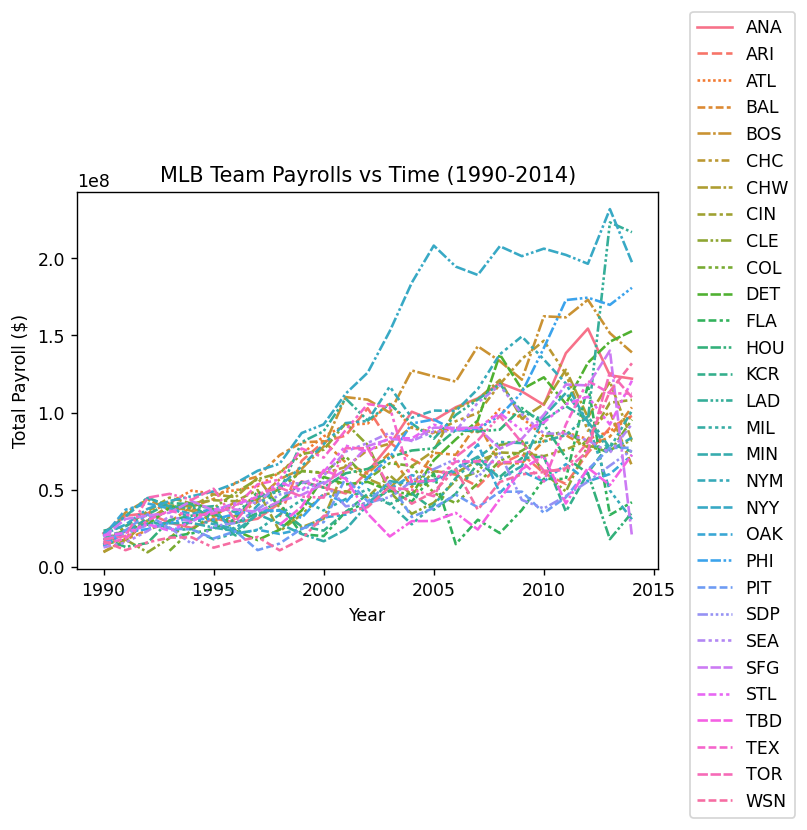

In [8]:
g = sns.lineplot(data=df_1990_pivot_fran)
g.legend(loc='upper right', bbox_to_anchor=(1.25, 1.5))
g.set_title('MLB Team Payrolls vs Time (1990-2014)')
plt.xlabel('Year')
plt.ylabel('Total Payroll ($)')

From the `lineplot` it appears that as time increases, the mean total_payroll as well as the spread of total_payroll distribution increases.

This plot looks a bit busy though, so let's simplify the plot to better show the distribution of payrolls conditioned on time. We will be using a `displot` for this, which uses darker colors to indicate a higher density.

Text(11.805555555555555, 0.5, 'Total Payroll ($)')

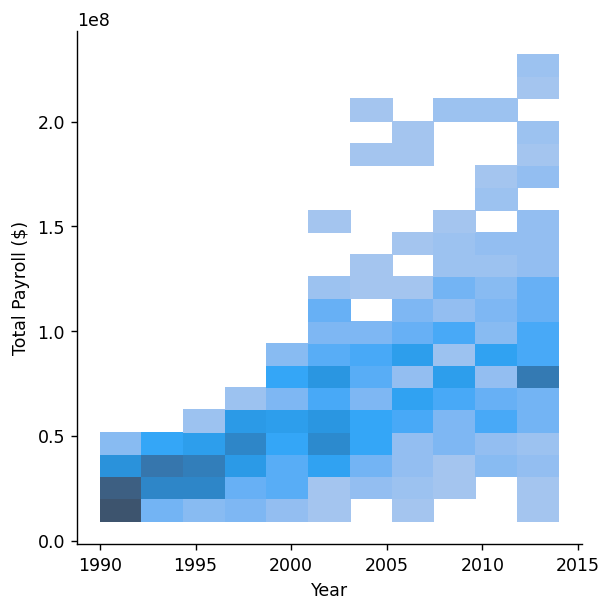

In [9]:
g = sns.displot(data=df_1990, x='yearID', y='total_payroll')
plt.xlabel('Year')
plt.ylabel('Total Payroll ($)')

This is better, but we can still improve our visualization to make the spread and central tendency more clear. To do this I will be using seaborn's `regplot`. This is a scatter plot where each data point is the total payroll for an MLB team durign a specific year. There is also a linear regression line with a 95% confidence interval included.

Text(0, 0.5, 'Total Payroll ($)')

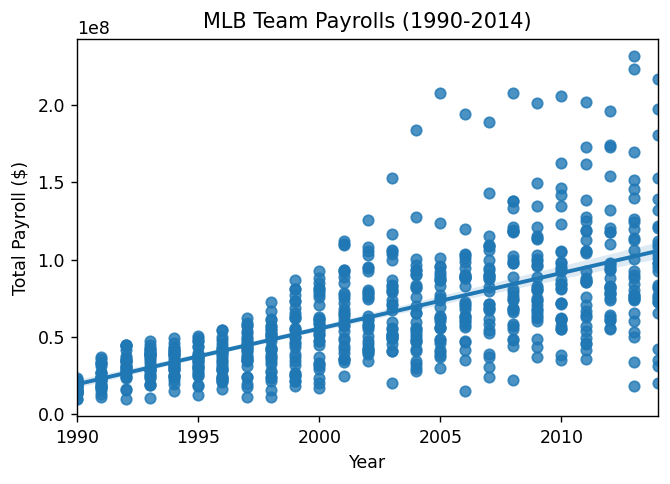

In [10]:
g = sns.regplot(data=df_1990, x='yearID', y='total_payroll').set_title('MLB Team Payrolls (1990-2014)')
plt.xlabel('Year')
plt.ylabel('Total Payroll ($)')

### Question 1

Now we can clearly see that the distribution of payroll becomes more spread out as time increases. 

Also the regression line shows a clear linear relationship, backed up by the rather tight confidence interval. Although notice the confidence interval grows larger in the later years as the spread increases.

### Problem 3

Let's create two histograms for the mean and standard deviation of `total_payroll` per `yearID` to confirm our observations in Question 1.

We'll create a new DataFrame called `yearly_stats` using pandas `groupby()` and `agg()` methods.
Our "group" will be `yearID`, and we will aggregate the mean and standard deviation of each variable using numpys' `np.mean` and `np.std`.


In [11]:
import numpy as np

yearly_stats = df_1990.groupby('yearID').agg([np.mean, np.std])
yearly_stats.head(1)

total_payroll               winning_percentage                 wins  \
                mean           std               mean       std       mean   
yearID                                                                       
1990    1.707235e+07  3.771834e+06          49.998525  5.585829  80.961538   

                       games            
             std        mean       std  
yearID                                  
1990    9.070748  161.923077  0.271746

We are only interested in the `total_payroll` at this time, so we will copy that to a new DataFrame that we can then use to plot our histograms

Text(0, 0.5, 'Average Payroll ($)')

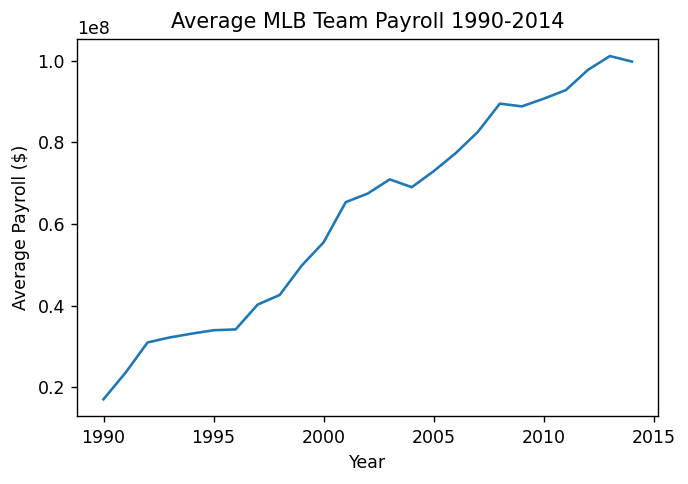

In [24]:
payroll_yearly_stats = yearly_stats['total_payroll']
payroll_yearly_stats.reset_index(inplace=True)

sns.lineplot(data=payroll_yearly_stats, x='yearID', y='mean').set_title('Average MLB Team Payroll 1990-2014')
plt.xlabel('Year')
plt.ylabel('Average Payroll ($)')


Text(0, 0.5, 'Payroll Std Dev ($)')

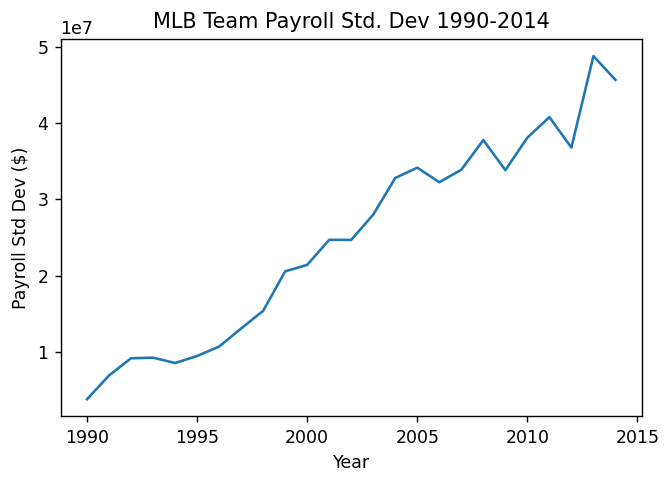

In [25]:

sns.lineplot(data=payroll_yearly_stats, x='yearID', y='std').set_title('MLB Team Payroll Std. Dev 1990-2014')
plt.xlabel('Year')
plt.ylabel('Payroll Std Dev ($)')

So we can visually confirm our observations from Question 1. The mean and standard deviation of MLB team payrolls increase as time increases, until the 2014 season, where both the mean and std dev decreased.  Teams are spending more money as time goes on, and the spread between the most and least wealthy team is also growing. 

Let it be noted that the payroll data has not been adjusted for inflation. Due to this it is possible the increase in average payroll is not as significant as it appears in the plots above. 

## *Correlation Between Payroll and Winning Percentage*

### Problem 4

Now that we've seen MLB teams are paying more money on average as the years go on, what do they have to show for it? Have teams that spent more earned themselves a higher winning percentage?

Let's continue to use our data from 1990-2014 and break those 25 years into 5 year segments. This will allow us to more precisely inspect the relationship between mean winning percentage and mean payroll. To do this we will use `pandas.cut` on our `df_1990` DataFrame, passing in an array with the bin criteria. We then use pandas `groupby` method to discretize our data into 5-year periods for each `franchID`. Next, we aggregate the `mean` of those groups. Finally, we drop the unnecessary `yearID` variable and the missing data (NaN), which stems from the franchises not existing between 1990-2000.

In [14]:
bins = [1990, 1995, 2000, 2005, 2010, 2014]
five_year_bins = df_1990.groupby([pd.cut(df_1990.yearID, bins), 'franchID']).mean()
five_year_bins_drop = five_year_bins.drop(['yearID', 'wins', 'games'], axis=1).dropna()
five_year_bins_drop.head(3)

total_payroll  winning_percentage
yearID       franchID                                   
(1990, 1995] ANA          30555411.6           46.586855
             ATL          38257841.6           60.973034
             BAL          30637691.4           50.864198

However now we have a `MultiIndex` which introduces problems when trying to plot our data because we want to be able to differentiate `franchID` as a variable not an index. So now we must perform some pandas magic using `iloc`, `get_level_values`, and `get_loc` to slice our MultiIndex DataFrame into separate DataFrames for each 5 year period.

In [15]:
period_dfs = [five_year_bins_drop.iloc[five_year_bins_drop.index.get_level_values(0).get_loc(1991 + x)] for x in range(0,21,5)]

Then we need to use `droplevel()` to remove the Interval level of the MultiIndex, and `reset_index` to convert the `franchId` index into a column.

In [16]:
for df in period_dfs:
    df.index = df.index.droplevel()
    df.reset_index(inplace=True)

There is most certainly a faster/cleaner way to do this, but it works and as the old saying goes ... "Don't fix what ain't broke".

Now we can use seaborn's `lmplot` to create a scatter plot with different colors to represent the MLB teams. Then we use `regplot` to add a regression line plot to the same figure.

After that we use `matplotlib.pyplot` methods to clean up the labels.

In [17]:
def problem4(df, years):
    g = sns.lmplot(data=df, x='total_payroll', y='winning_percentage', hue='franchID', fit_reg=False)
    sns.regplot(data=df, x='total_payroll', y='winning_percentage', ci=False, scatter=False, ax=g.axes[0, 0])
    plt.title(f'MLB Teams\' Spending Efficiency {years}')
    plt.xlabel('Avg Payroll')
    plt.ylabel('Avg Winning Percentage')

    for index, row in df.iterrows():
        plt.annotate(row['franchID'], # the text for each label
                    (row['total_payroll'], row['winning_percentage']), # the coords of the point
                    ha='center') # horizontal alignment

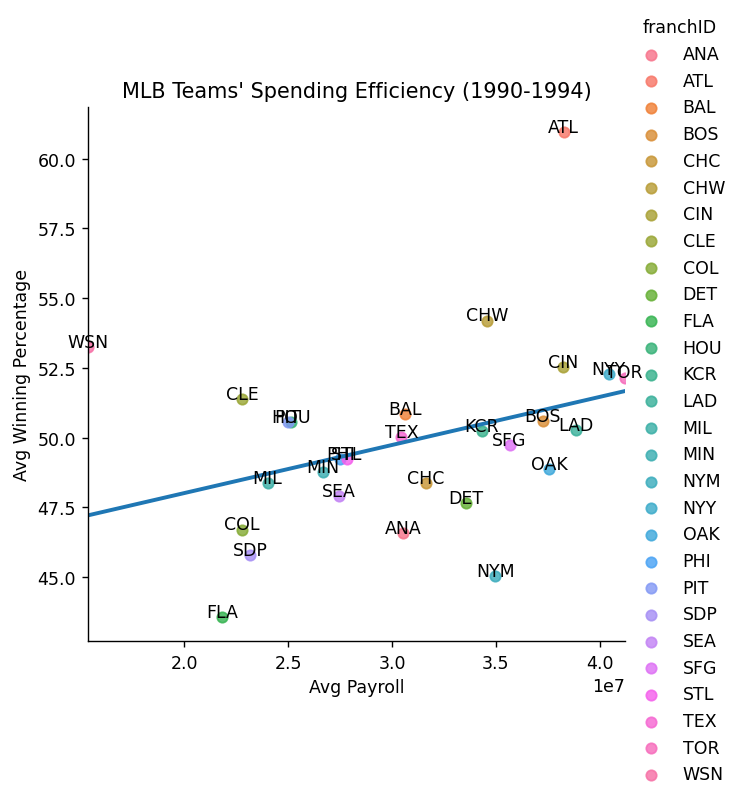

In [18]:
problem4(period_dfs[0], '(1990-1994)')

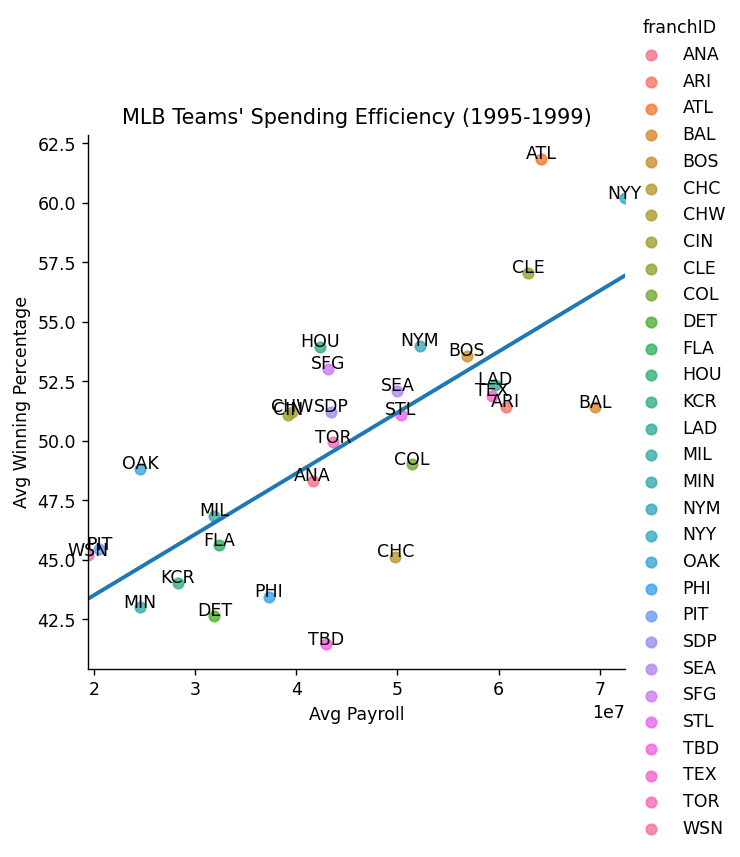

In [19]:
problem4(period_dfs[1], '(1995-1999)')

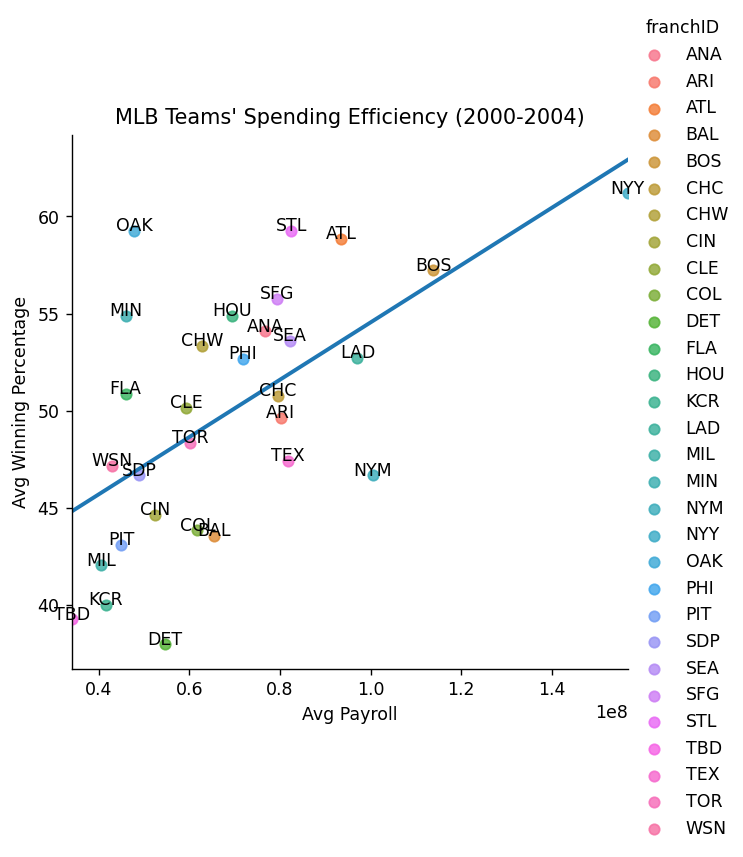

In [20]:
problem4(period_dfs[2], '(2000-2004)')

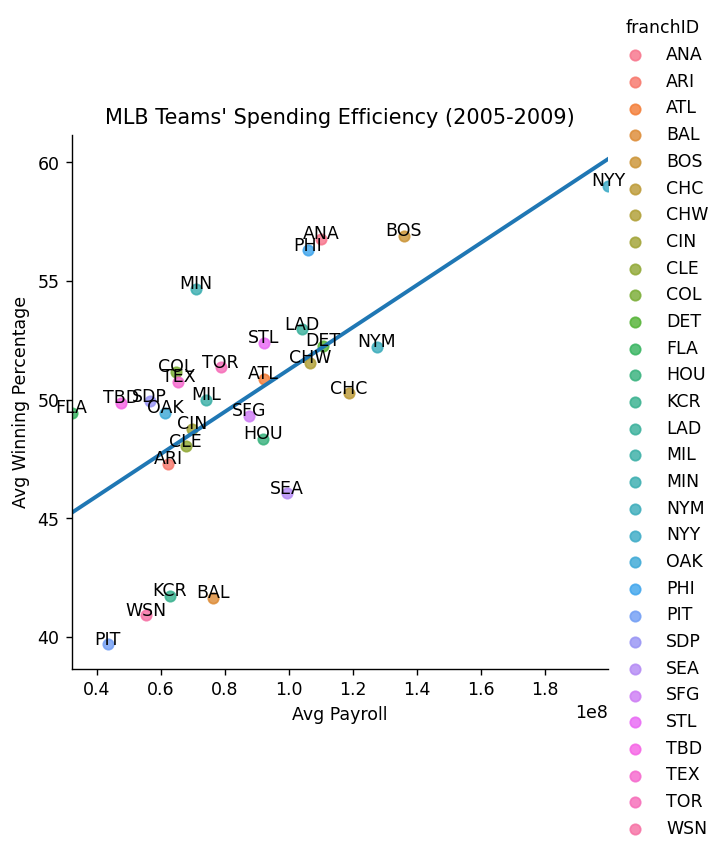

In [21]:
problem4(period_dfs[3], '(2005-2009)')

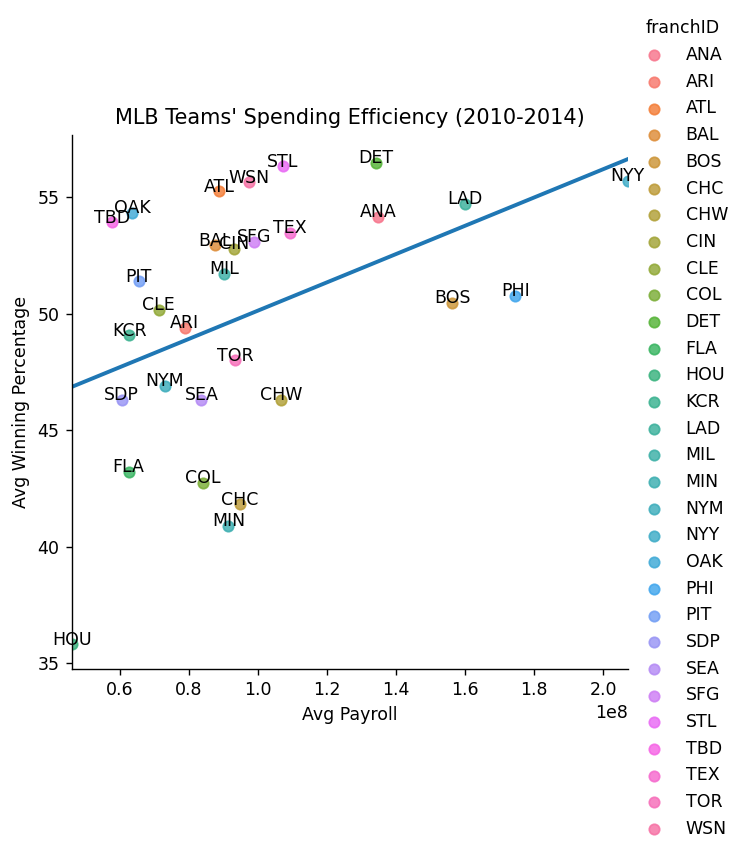

In [22]:
problem4(period_dfs[4], '(2010-2014)')

### Question 2

From these plots we can observe a positive linear relationship between average payroll and average winning percentage during every five-year period. Heuristically, we can judge the individual teams' distance above/below the regression line as more/less efficienct.

For the following periods there are some clear winners.
    >1990-1994: ATL

    >1995-1999: ATL

    >2000-2004: OAK

    >2005-2009: MIN

However for during the 2010-2014 period, there are multiple teams that appear to be the same distance above the regression line. Perhaps they caught on to the analytics taking place in clubhouses such as Oakland.

As far as the topic of our movie, _Moneyball_, it was far-and-away the most efficient team during the 2000-2004 time period. This matches our expectations, as this is when they implemented an analytics program focused on cost efficiency. In fact, in all time periods analyzed Oakland had a "positive" efficiency. They were even one of the teams tied for most efficient during 2010-2014. So it appears that their plan worked.


---
## **Part 3: Data Transformations**
---

## *Standardizing Across Years*

### Problem 5

To be consistent and test our hypothesis stated previously in this report, we will continue to analyze the data between 1990-2014. 

We shall now standardize the payrolls so that we may more accurately compare it across years. To do this we will first need to perform a merge on our `df_1990` and `payroll_yearly_stats` DataFrames. We will use the equivalent of a `LEFT OUTER JOIN ON df_1990.yearID = payroll_yearly_stats.yearID` , but using pandas' `merge()` function. Once we have all the info in our new `df_1990_merged` DataFrame, we can create a new variable `standardized_payroll` in it using a vectorized operation of ((payroll - mean_payroll) / std_dev). This is essentially creating our own z-score for payrolls.

In [29]:
df_1990_merged = pd.merge(df_1990, payroll_yearly_stats, on='yearID', how='left')

def standardize(p, m, s):
   return (p - m) / s

df_1990['standardized_payroll'] = list(map(standardize, df_1990['total_payroll'], df_1990_merged['mean'], df_1990_merged['std']))

df_1990.head()

,yearID,teamID,franchID,lgID,total_payroll,winning_percentage,wins,games,standardized_payroll
130,1990,ATL,ATL,NL,14555501.0,40.123457,65,162,-0.667275
131,1990,BAL,BAL,AL,9680084.0,47.204969,76,161,-1.959861
132,1990,BOS,BOS,AL,20558333.0,54.320988,88,162,0.924213
133,1990,CAL,ANA,AL,21720000.0,49.382716,80,162,1.232198
134,1990,CHA,CHW,AL,9491500.0,58.024691,94,162,-2.009859


In [ ]:
Now we just repeat the same process from Problem 4 but use 

In [31]:
five_year_bins2 = df_1990.groupby([pd.cut(df_1990.yearID, bins), 'franchID']).mean()
five_year_bins_drop2 = five_year_bins2.drop(['yearID', 'wins', 'games'], axis=1).dropna()
five_year_bins_drop2.head(3)

period_dfs2 = [five_year_bins_drop2.iloc[five_year_bins_drop2.index.get_level_values(0).get_loc(1991 + x)] for x in range(0,21,5)]

for df in period_dfs2:
    df.index = df.index.droplevel()
    df.reset_index(inplace=True)

In [33]:
def problem6(df, years):
    g = sns.lmplot(data=df, x='standardized_payroll', y='winning_percentage', hue='franchID', fit_reg=False)
    sns.regplot(data=df, x='standardized_payroll', y='winning_percentage', ci=False, scatter=False, ax=g.axes[0, 0])
    plt.title(f'MLB Teams\' Spending Efficiency {years}')
    plt.xlabel('Avg Standardized Payroll')
    plt.ylabel('Avg Winning Percentage')

    for index, row in df.iterrows():
        plt.annotate(row['franchID'], # the text for each label
                    (row['standardized_payroll'], row['winning_percentage']), # the coords of the point
                    ha='center') # horizontal alignment

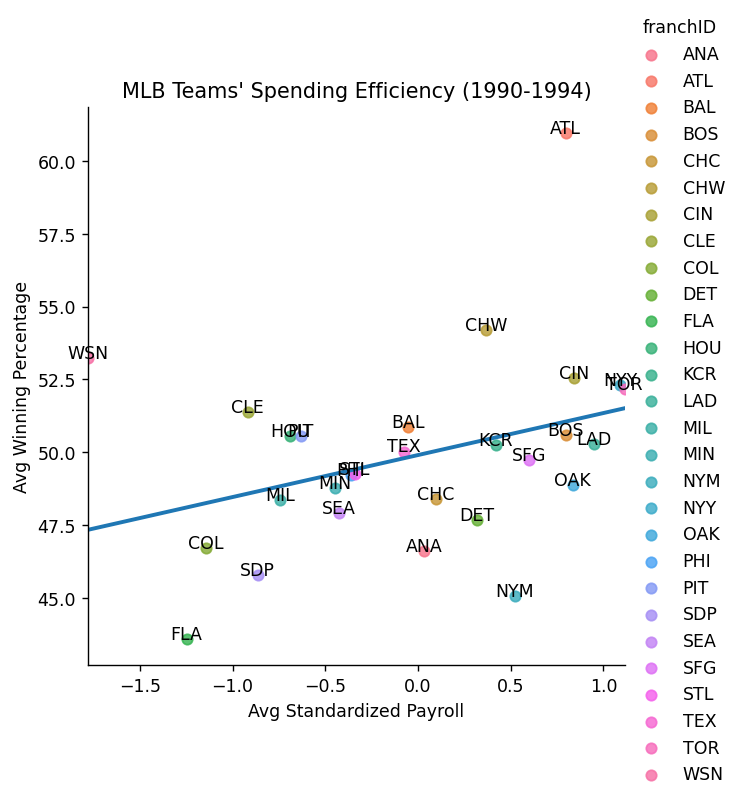

In [34]:
problem6(period_dfs2[0], '(1990-1994)')

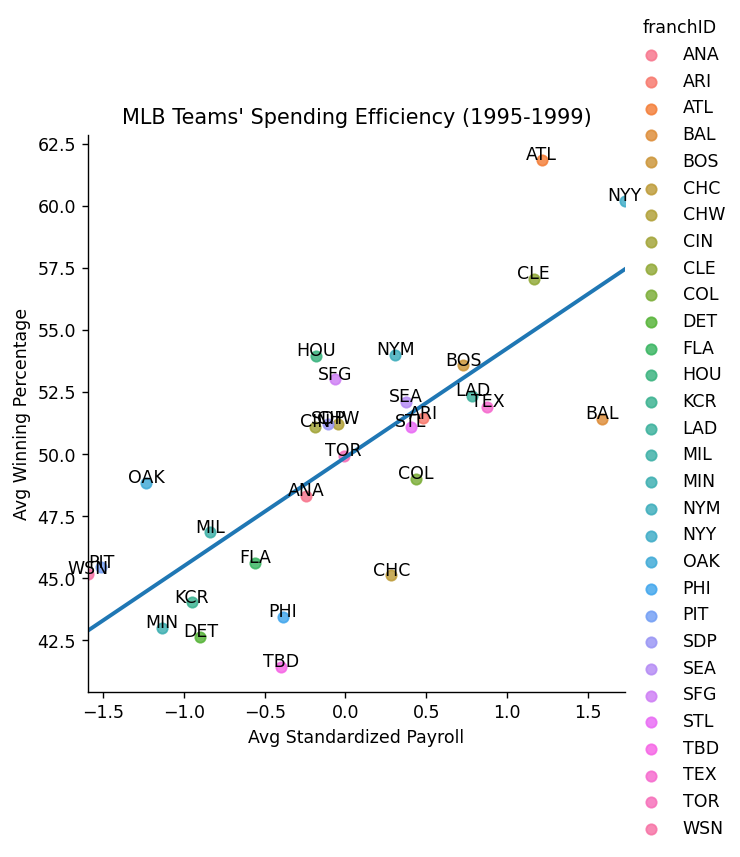

In [35]:
problem6(period_dfs2[1], '(1995-1999)')

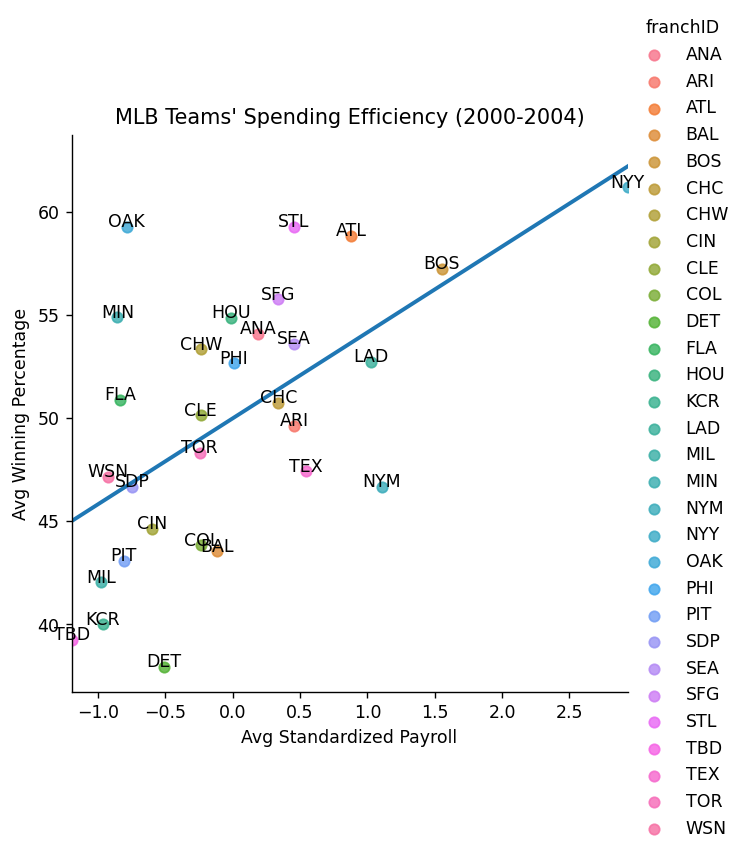

In [36]:
problem6(period_dfs2[2], '(2000-2004)')

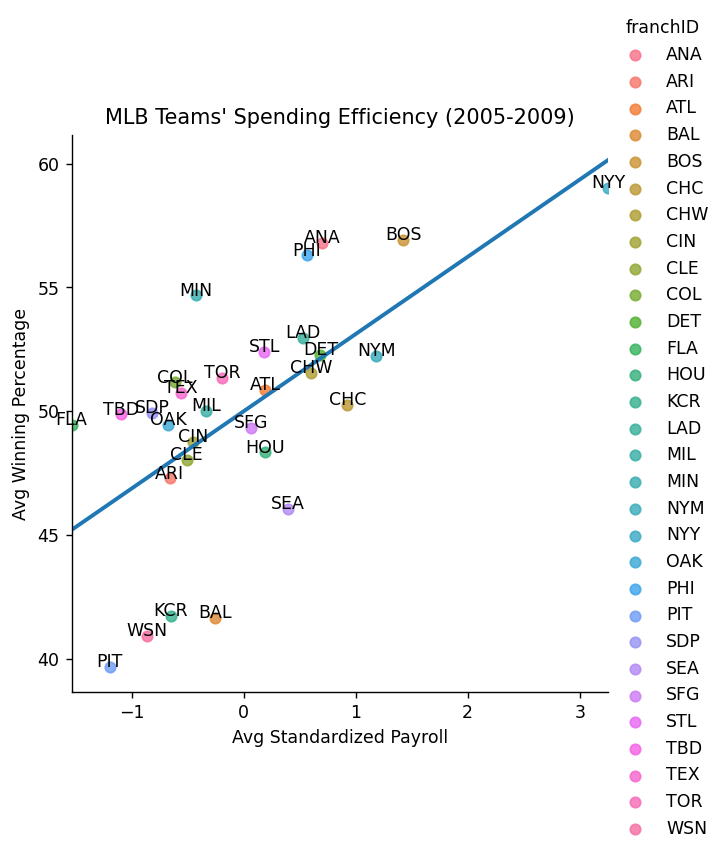

In [37]:
problem6(period_dfs2[3], '(2005-2009)')

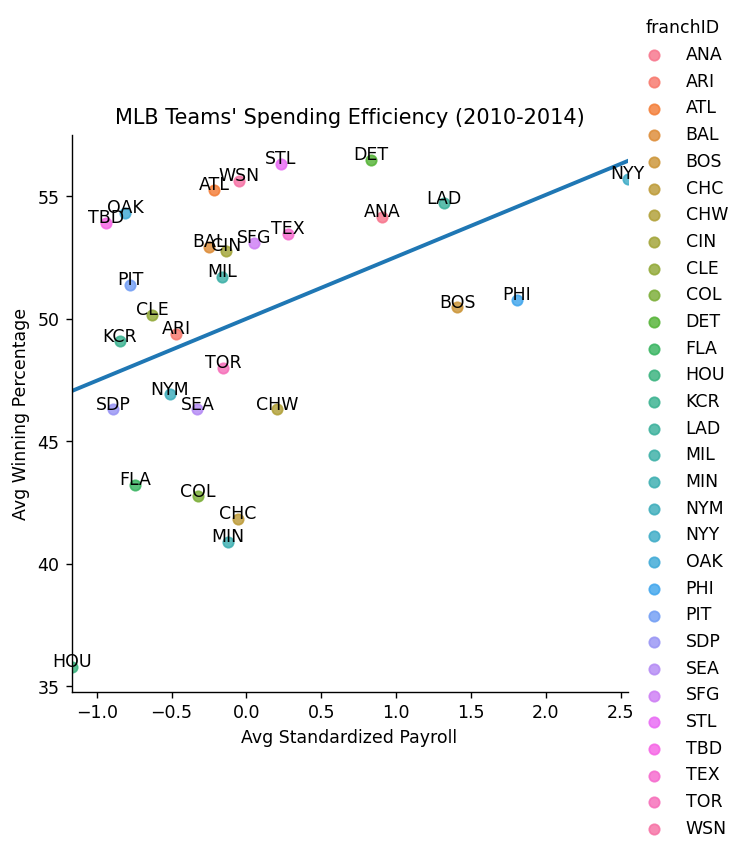

In [38]:
problem6(period_dfs2[4], '(2010-2014)')

### Question 3

The plots from Problem 4 and Problem 6 relflect the transformation we performed in the difference beween the x-axis. The Problem 4 plots have Avg Payrolls who's scales have an a single order of magnitude difference from 2000-2014. There is no way we can directly compare these.

So when we standardized we found the difference between a team's payroll and the average payroll for that year. However, this itself is not standardized because the range of payrolls and the average payroll change every year. So, in order to standardize, we divide the difference by the standard deviation for that year. This way we have a common metric to determine how much more or less than average a team is spending for that year.

## *Expected Wins*

### Problem 7

It's hard to see global trends across time periods using these multiple plots, but now that we have standardized payrolls across time, we can look at a single plot showing correlation between winning percentage and payroll across time.

Text(0, 0.5, 'Winning Percentage')

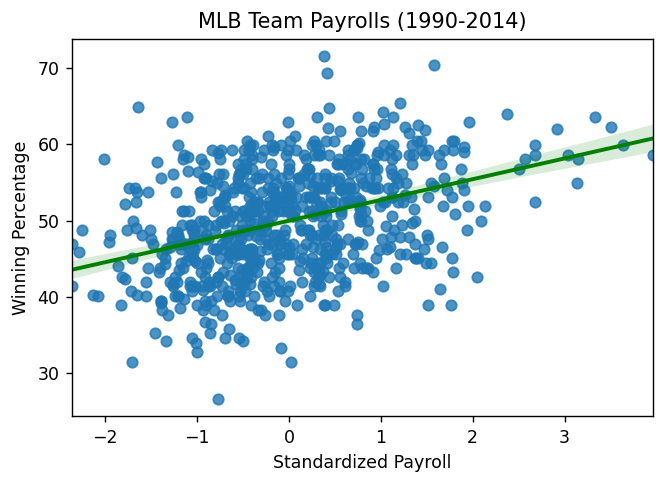

In [46]:
g = sns.regplot(data=df_1990, x='standardized_payroll', y='winning_percentage', line_kws={'color':'g'}).set_title('MLB Team Payrolls (1990-2014)')
plt.xlabel('Standardized Payroll')
plt.ylabel('Winning Percentage')

 Looking at the regression line, it looks like teams that spend roughly the average payroll in a given year will win 50% of their games (i.e. win_pct is 50 when standardized_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll (i.e., win_pct is 55 when standardized_payroll is 2). 

From these observations we can calculate the expected win percentage for team i in year j as:
    >`expected_win_pct = 50 + 2.5 * standardized_payroll`



 

In [47]:
def expect(s):
    return 50 + 2.5 * s

df_1990['expected_win_pct'] = list(map(expect, df_1990['standardized_payroll']))

## *Spending Efficiency*

Using this result, we can now create a single plot that makes it easier to compare teams efficiency. The idea is to create a new measurement unit for each team based on their winning percentage and their expected winning percentage that we can plot across time summarizing how efficient each team is in their spending.

### Problem 8

We will create a new variable to compute each team's spending efficiency, given by:
    > `efficiency = win_pct - expected_win_pct`

In [49]:
df_1990['efficiency'] = list(map(np.subtract, df_1990['winning_percentage'], df_1990['expected_win_pct'])) 

Text(0, 0.5, 'Win Efficiency')

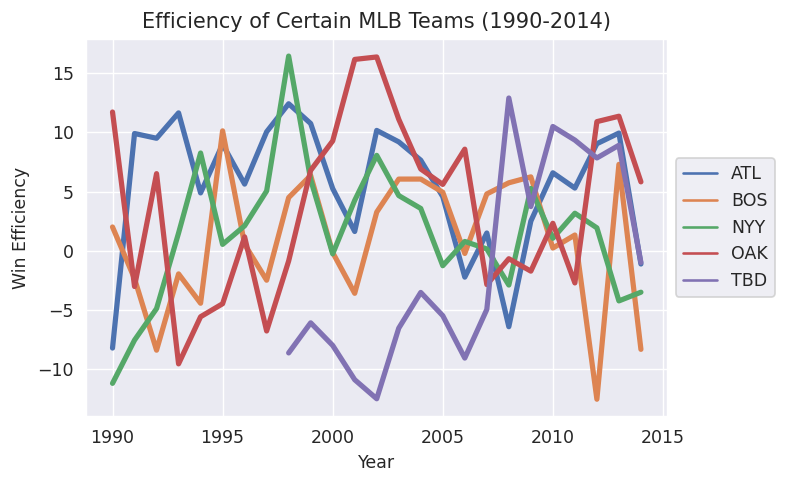

In [81]:
problem8_df = df_1990.loc[(df_1990['franchID'] == 'OAK') | (df_1990['franchID'] == 'BOS') | (df_1990['franchID'] == 'NYY') | (df_1990['franchID'] == 'ATL') | (df_1990['franchID'] == 'TBD')]

sns.set_style('darkgrid')
g = sns.lineplot(data=problem8_df, x='yearID', y='efficiency', hue='franchID', palette='deep', **{'lw': 3.0})
g.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
g.set_title('Efficiency of Certain MLB Teams (1990-2014)')
plt.xlabel('Year')
plt.ylabel('Win Efficiency')

### Question 4

This plot is different that those from Question 2 and Question 3 because we have a tanglible metric for efficiency, instead of hypothesizing based on distance from the regression line. We are able to tell how much each team beat their expected win percentage from 1990-2014. This allows us to directly compare different times efficiency in different seasons becuase the expected win percentage is based on the standardized payroll.

During the Moneyball period, the Oakland Athletics peaked at just above 15% efficiency. This means they won 15% more games than they were expected to based on their salary. It is higher than every other team except or the New York Yankees in the late 90's. This confirms the idea that the Oakland A's had an extraordinarily efficient scouting process during the Moneyball period.



